In [1]:
#Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import time
import pickle

## Import data, shuffle


In [2]:
def read_rgb(img_file):
    """
    To be consistent with reading images, I'll use cv2, which reads images
    as BGR with scale 0 to 255.
    
    Since matplotlib.image scales 0 to 1 for png but 0 to 255 for jpg, as RGB,
    I'll chooose cv2 to read the image, then convert BGR to RGB
    I will keep the scale as 0 to 255, because if I change color spaces,
    the scale will be 0 to 255 again.
    
    I'll use StandardScaler() to standardize features later in the pipeline.
    """
    img = cv2.imread(img_file)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
def convert_color(img, color_space='RGB'):
    """
    img: an RGB image
    color_space: HSV, LUV, HLS, YUV, YCrCb
    returns: a new image converted to the chosen color space, else a copy of the original image
    """
    if color_space == 'HSV':
        img_out = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        img_out = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        img_out = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        img_out = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        img_out = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        img_out = np.copy(img)
        
    return img_out

In [4]:
def bin_spatial(img, size=(32, 32)):
    """
    compute binned color features  
    Use cv2.resize().ravel() to create the feature vector
    ravel flattens the n-dim array to a 1D array
    """
    features = cv2.resize(img, size).ravel()
    return features

In [5]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    compute color histogram features
    numpy.histogram returns both the histogram counts and the bins as array index 0 and 1
    Make the list of arrays into an array, 
    then flatten as if we're concatenating each histogram one after the other
    returns a numpy array of histogram values for all channels
    """
    hists = []
    for channel in range(img.shape[2]):
        hist, bind_edges = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
        hists.append(hist)
    hist_features = np.array(hists).ravel() 
    return hist_features

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     feature_vec=True, hog_channel='ALL'):
    """
    return HOG features and visualization
    img: image from which to extract histogram of gradients,
        will have 3 channels.
    orient: number of gradient orientations
    pix_per_cell: size of cell in pixels
    cell_per_block: size of block (in cells)
    vis: if True, returns an image representing the found histogram of gradients
    feature_vec: if True, flattens result into 1d array using numpy.ravel()
    hog_channel: 'ALL' uses all channels, else 0 to 3 representing the channel to use
    """
    if hog_channel == 'ALL': #use all channels
        hog_features = []
        for channel in range(img.shape[2]):
            features = hog(img[:,:,channel],
                           orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           transform_sqrt=True, 
                           visualise=False,
                           feature_vector=feature_vec)
            hog_features.append(features)
        hog_features = np.ravel(hog_features)
    else: #use chosen channel
        hog_features = hog(img[:,:,hog_channel],
                           orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           transform_sqrt=True, 
                           visualise=False,
                           feature_vector=feature_vec)
    return hog_features

In [7]:
def extract_features(paths, color_space='HLS', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), 
                     orient=9, pix_per_cell=8, cell_per_block=2):
    """
    paths: list of file paths for images (either vehicle or non-vehicle)
    color_space: HSV, LUV, HLS, YUV, YCrCb, otherwise don't change color space.
    
    I'll choose HLS color space and HOG will use all 3 channels.
    
    feature vectors are a concatenation of spatial, histogram, and hog vectors.
    
    features is a list of feature vectors.  These will be stacked as rows,
    so that one row is for each image, and each column represents a particular feature.
    
    With default parameters, spatial_feature is 3072, hist is 96, and hog is 5292. 
    Total length of features is 8460
    
    To reduce feature size, I'll use saturation for spatial and hog features,
    to reduce channels from 3 to 1
    """
    features = []
    for file in paths:
        image = read_rgb(file)
        feature_image = convert_color(image, color_space)
        feature_saturation = feature_image[:,:,2]
        spatial_features = bin_spatial(feature_saturation, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        hog_features = get_hog_features(feature_image, orient, pix_per_cell, cell_per_block, 
                                        feature_vec=True, hog_channel=2) #channel 2 is saturation in HLS
        feature_vector = np.concatenate((spatial_features, hist_features, hog_features))
        features.append(feature_vector)
        """
        print("spatial {}, hist{}, hog {}, sum {}, feature_vector {}".format(spatial_features.size,
                                                 hist_features.size,
                                                 hog_features.size,
                                                 spatial_features.size + hist_features.size + hog_features.size,
                                                 feature_vector.size
                                                ))
        """
    return features

## Getting data (run once).  See below for loading extracted features

In [ ]:
#def get_data():
cars_paths = glob.glob('./vehicles/*/*.png') #8792 
other_paths = glob.glob('./non-vehicles/*/*.png') #8968


In [78]:
"""
default
feature sizes:
spatial: 8x8x3 = 768
hist: 32 x 3 = 96
hog: 5292 = 7 x 7 x 2 x 2 x 9 x 3 = 

modified to reduce feature set:
feature sizes:
spatial: 16x16x3 = 768
hist: 32 x 3 = 96
hog: 432: 1 x 1 x 4 x 4 x 9 x 3

3rd try reducing channels
for spatial and hog, use saturation channel only
spatial: 16 x 16 x 1 = 256
hist: 32 x 3 = 96
hog: 1 x 1 x 8 x 8 x 9 x 1 = 576

So, the actual number of features in your final feature vector will be the total number of block positions 
multiplied by the number of cells per block, 
times the number of orientations, or in the case shown above: 7×7×2×2×9=1764 (also x3 for 3 channels)
spatial: 32 x 32
histogram: 32 bins
hog: 9 orient, 8 pix per cell, 8 cell per block
"""

t0 = time.time()
car_features = extract_features(cars_paths, color_space='RGB', 
                                spatial_size=(32, 32),
                                hist_bins=32, hist_range=(0, 256),
                                orient=9, pix_per_cell=8, cell_per_block=8)

other_features = extract_features(other_paths, color_space='RGB', 
                                spatial_size=(32, 32),
                                hist_bins=32, hist_range=(0, 256),
                                orient=9, pix_per_cell=8, cell_per_block=8)
t1 = time.time()
print("time to extract features {:.1f}".format(t1 - t0))

/Users/edude/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


time to extract features 271.1


In [79]:
t0 = time.time()
# Create an array stack of feature vectors
X = np.vstack((car_features, other_features)).astype(np.float64)                        
# Fit a per-column scaler (each column represents a feature, and is normalized)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(other_features))))

#training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=14)

t1 = time.time()
print("time to standardize and split training and test sets {:.1f} seconds".format(t1 - t0))

time to standardize and split training and test sets 8.4 seconds


In [81]:
"""
Saving to pickle with these params
3rd try reducing channels
for spatial and hog, use saturation channel only
spatial: 16 x 16 x 1 = 256
hist: 32 x 3 = 96
hog: 1 x 1 x 8 x 8 x 9 x 1 = 576
"""


t0 = time.time()
# use pickle to save train and test sets
pickle_path = 'data_dict_pickle.p'
data_dict = {}
data_dict['X_train'] = X_train
data_dict['X_test'] = X_test
data_dict['y_train'] = y_train
data_dict['y_test'] = y_test
pickle.dump( data_dict, open( pickle_path, "wb" ) )
t1 = time.time()
print("time to save train and test data_dict to file {:.1f} seconds".format(t1 - t0))

time to save train and test data_dict to file 11.2 seconds


## Load train and test data from disk

In [8]:
"""
feature set is 1696 long
spatial: 32 x 32: saturation channel only
histogram of colors: 32 bins, Hue, light and saturation channels
histogram of gradients: pix_per_cell 8; cell_per_block 8; just saturation channel
"""
pickle_path = 'data_dict_pickle.p'
data_dict = pickle.load( open(pickle_path, 'rb')) 
X_train, X_test, y_train, y_test = data_dict['X_train'],data_dict['X_test'], data_dict['y_train'], data_dict['y_test']

## Use decision tree to get feature importance, narrow down feature set

In [69]:
t0 = time.time()
tree_clf = DecisionTreeClassifier(min_samples_split=500)
tree_clf = tree_clf.fit(X_train, y_train)
t1 = time.time()
print("time to train decision tree {:.1f} seconds".format(t1 - t0))

time to train decision tree 48.1 seconds


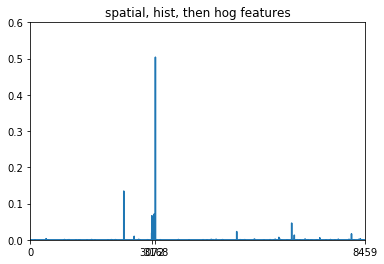

In [57]:
"""
plot feature importances
spatial_feature is length 3072, hist is 96, and hog is 5292. 
when concatenated,
spatial is from 0 to 3071, 
hist is from 3072 to 3167
hog is from 3168 to 8459 
  within hog, the first 1764 are for hue, second is for light, 3rd for saturation
  tick marks are 3168 to 4931, 4932 to 6695, 6696 to 8459

By plotting the feature importances, looks like the histogram of colors in HLS
has the highest feature importance.
"""
plt.plot(tree_clf.feature_importances_)
x_tick_labels = [0, 3072, 3168, 8459] #labels x axis tick marks at specific indices
plt.xticks(x_tick_labels);
plt.axis([0, 8460, 0, 0.6]); #min/max range of x axis, then min/max range of y axis
plt.title("spatial, hist, then hog features");
plt.show();

In [70]:
len(tree_clf.feature_importances_)

1296

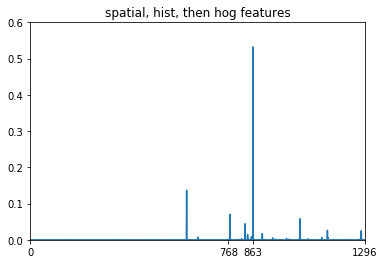

In [71]:
#with new params: 
"""
feature sizes:
spatial: 16x16x3 = 768
hist: 32 x 3 = 96
hog: 432: 1 x 1 x 4 x 4 x 9 x 3
plot feature importances
spatial_feature is length 3072, hist is 96, and hog is 5292. 
when concatenated,
spatial is from 0 to 767, 
hist is from 768 to 863
hog is from 864 to 1295
  within hog, the first 1764 are for hue, second is for light, 3rd for saturation
  tick marks are 3168 to 4931, 4932 to 6695, 6696 to 8459

By plotting the feature importances, looks like the histogram of colors in HLS
has the highest feature importance.
"""
plt.plot(tree_clf.feature_importances_)
x_tick_labels = [0, 768, 864, 1295] #labels x axis tick marks at specific indices
plt.xticks(x_tick_labels);
plt.axis([0, 1295, 0, 0.6]); #min/max range of x axis, then min/max range of y axis
plt.title("spatial, hist, then hog features");
plt.show();

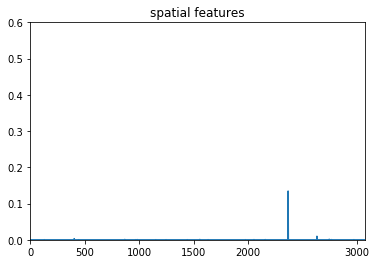

In [49]:
#spatial is from 0 to 3071, 
plt.plot(tree_clf.feature_importances_)
x_tick_labels = [0, 500, 1000, 1500, 2000, 3000] #labels x axis tick marks at specific indices
plt.xticks(x_tick_labels);
plt.axis([0, 3071, 0, 0.6]); #min/max range of x axis, then min/max range of y axis
plt.title("spatial features");
plt.show();

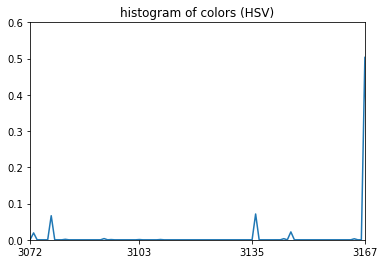

In [58]:
#hist is from 3072 to 3167
plt.plot(tree_clf.feature_importances_)
x_tick_labels = [3072, 3103, 3135, 3167] #labels x axis tick marks at specific indices
plt.xticks(x_tick_labels);
plt.axis([3072, 3167, 0, 0.6]); #min/max range of x axis, then min/max range of y axis
plt.title("histogram of colors (HSV)");
plt.show();

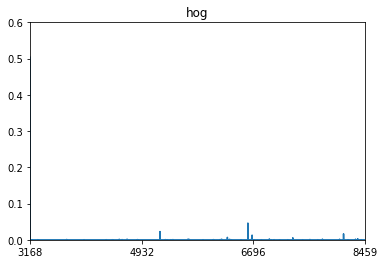

In [59]:
"""
hog is from 3168 to 8459 
  within hog, the first 1764 are for hue, second is for light, 3rd for saturation
  tick marks are 3168 to 4931, 4932 to 6695, 6696 to 8459
  only light has some significance, hue and saturation less so.
"""
plt.plot(tree_clf.feature_importances_)
x_tick_labels = [3168, 4932, 6696, 8459] #labels x axis tick marks at specific indices
plt.xticks(x_tick_labels);
plt.axis([3168, 8459, 0, 0.6]); #min/max range of x axis, then min/max range of y axis
plt.title("hog");
plt.show();

## SVC

In [9]:
# Use a linear SVC on spatial, hist, and hog features
"""
Got these results with these parameters:

spatial: 32 by 32
hist: 32 bins
hog: 8 pix by 8 pix, cells per block 2

155.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9842
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.01815 Seconds to predict 10 labels with SVC
"""
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


10.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00505 Seconds to predict 10 labels with SVC


In [72]:
# Use a linear SVC on spatial, hist, and hog features
"""
Got these results with new smaller parameters:

spatial: 16 by 16
hist: 32 bins
hog: 16 pix by 16 pix, cells per block 4

5.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9778
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00506 Seconds to predict 10 labels with SVC


It's much faster with a smaller hog feature set.
test accuracy is a little less than when using the default parameters
"""
svc = LinearSVC() # C=1
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


5.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9778
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00506 Seconds to predict 10 labels with SVC


In [ ]:
"""
LinearSVC with C=0.1
"""

In [82]:
len(X_train[0])

1696

### Chosen feature set

In [80]:
# Use a linear SVC on spatial, hist, and hog features
"""
Got these results w/ 3rd set of params.
I will use these going forward, because accuracy is good enough
while I reduced the feature set from 8 thousand to 1.6 thousand

spatial: 32 by 32: 32x32x1 = 1024
hist: 32 bins: 96
hog: 8 pix by 8 pix, cells per block 8: 8x8x1x1x9x1 = 576
feature set is 1696 long

11.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.01061 Seconds to predict 10 labels with SVC


test accuracy is a little less than when using the default parameters
"""
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


11.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.01061 Seconds to predict 10 labels with SVC


In [60]:
#try using svc on only 96 histogram features only 3072 to 3167 
# Use a linear SVC on spatial, hist, and hog features
"""
Not final feature set.  This just shows that histogram of colors
gets good accuracy, but it's still better to use other features.

train linear SVC on histogram of colors 96 features
0.22 Seconds to train SVC...
Test Accuracy of SVC =  0.9147
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.009 Seconds to predict 10 labels with SVC
"""
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print("train linear SVC on histogram of colors 96 features")
svc.fit(X_train[3072:3167], y_train[3072:3167])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


train linear SVC on histogram of colors 96 features
0.22 Seconds to train SVC...
Test Accuracy of SVC =  0.9147
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.009 Seconds to predict 10 labels with SVC


In [61]:
#try using svc on spatial and hist features only 0 to 3167 
# Use a linear SVC on spatial, hist, and hog features
"""
This is not the final feature set.
train linear SVC on spatial plus histogram of colors 3168 features
This shows that excluding histogram of gradients reduces accuracy
by just a little bit.

8.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9755
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00586 Seconds to predict 10 labels with SVC
"""
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print("train linear SVC on spatial plus histogram of colors 3168 features")
svc.fit(X_train[0:3167], y_train[0:3167])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


train linear SVC on spatial plus histogram of colors 3168 features
8.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9755
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00586 Seconds to predict 10 labels with SVC


In [73]:
#with new params (smaller featuer set)
"""
Not final feature set used. 
This just shows that reducing the spatial set reduced the accuracy 
by enough that I don't want to use the 16x16 spatial set (32x32 is better)
use spatial and hist of colors only (index 0 to 863)
spatial is from 0 to 767, 
hist is from 768 to 863
hog is from 864 to 1295

train linear SVC on spatial plus histogram of colors 3168 features
0.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9581
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00292 Seconds to predict 10 labels with SVC

"""
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print("train linear SVC on spatial plus histogram of colors 3168 features")
svc.fit(X_train[0:863], y_train[0:863])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


train linear SVC on spatial plus histogram of colors 3168 features
0.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9581
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00292 Seconds to predict 10 labels with SVC


## Parameter tuning of SVC

In [ ]:
"""

large C fits training data better at the cost of overfitting
gamm param applies for rbf kernel, but not linear kernel
large gamma places more emphasis on points close to decision boundary, and less on far away points.
A larger gamma may be less smooth compared to a low gamma, which accounts for more points.

For grid search, use 10-fold stratified cross validation

"""
t0 = time.time()
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.1, 1, 10]}
parameters = {'kernel':('rbf',), 'C':[1, 10], 'gamma':[1]}
svr = SVC()
gs = GridSearchCV(svr, parameters, cv=3)
gs.fit(X_train,y_train)
t1 = time.time()
print("time to run grid search on SVC {:.1f}".format(t1 - t2))

In [ ]:
print("best params: {}".format(gs.best_params_))

In [16]:
"""
LinearSVC, C = 0.001

5.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9831
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00537 Seconds to predict 10 labels with SVC
"""

svc = LinearSVC(C=0.001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9831
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.0052 Seconds to predict 10 labels with SVC


## Best C is 0.01

In [13]:
"""
LinearSVC, C = 0.01

7.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9837
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00626 Seconds to predict 10 labels with SVC
"""

svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9837
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00626 Seconds to predict 10 labels with SVC


In [10]:
"""
LinearSVC, C = 0.1

10.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00455 Seconds to predict 10 labels with SVC
"""

svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

10.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00455 Seconds to predict 10 labels with SVC


In [12]:
"""
LinearSVC, C = 1

9.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9797
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00439 Seconds to predict 10 labels with SVC
"""

svc = LinearSVC(C=1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9797
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00439 Seconds to predict 10 labels with SVC


In [11]:
"""
LinearSVC, C = 10.
Does worse than C= 1 or 0.1.
It's probably over-fitting

9.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9792
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00407 Seconds to predict 10 labels with SVC
"""

svc = LinearSVC(C=10)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9792
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00407 Seconds to predict 10 labels with SVC


## Tune rbr kernel with C = 0.01, adjust gamma

In [17]:

"""
rbf kernel takes longer than linear kernel
and performs much worse. I'll stay with LinearSVC
SVC kernel rbf, C = 0.01, gamma = 1

616.62 Seconds to train SVC...
Test Accuracy of SVC =  0.4975
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.38444 Seconds to predict 10 labels with SVC

"""

svc = SVC(kernel='rbf', C=0.01, gamma=1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

616.62 Seconds to train SVC...
Test Accuracy of SVC =  0.4975
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.38444 Seconds to predict 10 labels with SVC


# Window search